**Each presentation will last 30 minutes (20 minutes + 10 minutes for questions).**

During the project we expect you to write a report using a Notebook Python (.ipynb, same format as the practical session).
The articles cover several topics we discussed during the courses (Hamiltonian Monte Carlo, Pseudo-Marginal algorithm, variational inference). Each report is expect to contain (at least):

- A description of the context of the article (model, specific challenge and objective of the algorithm).

- A clear description of the algorithm introduced in the paper with a discussion on its specificities (tuning parameters, etc.) with respect to the algorithm we studied during the courses.

- Numerical illustrations of the algorithm at least on a simulated dataset (with discussion on its performance). 

Note that the papers do not contain the same level of technicalities. To select the project read carefully the abstract and introduction to choose according to your affinities about the algorithms and their objectives. For the most complex papers, we do not expect you to rewrite all the proofs and understand all technical details.

Group 13 - Project 5  
Lotfi Kobrosly, Yuhe Bai, Pierre-André Mikem and Nawel Arab  
**Tuesday 15th December 10h30** -  Project 10 &  Project 5 


# Introduction




In [179]:
import scipy.io as sio
import random
from scipy.sparse import coo_matrix
import numpy as np
import time
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# PULA

**This python function implements the proximal unadjusted Langevin algorithm described in**  
[1] M. Pereyra, "Proximal Markov chain Monte Carlo algorithms," submitted to Journal Royal Statistics Society: Series B.  
E-print available on Arxiv: http://arxiv.org/abs/1306.0187  
**Inputs**  
- X0 : initial state of the Markov chain
- proxg : function handler of type @(X,lambda) for the lambda-proximity mapping of g(x) = \log\pi(x)
- options (stucture) 

  **Required**:    
  - options.samples : number of output samples
  - options.delta : initial value of the time-discretisation step(this value may be adapted during the burn-in period to improve the acceptance rate)

  **Optional**:  
  - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)  
  - options.display    : display progressbar (1) do not display (0)

**Outputs**
- Xchain : Makov chain generated by P-ULA 
- time : cpu time

In [180]:
def pula(X0=None,proxg=None,options=None):
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
  n = X0.shape # gives num of rows and cols of X0
  Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 

  # Initialize variables
  delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
  Xcur = X0               # set initial state as current state
  
  if n[1]==1:
    Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
  else:
    Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #  progressbar

  time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
  for ii in range(1, int(options['samples'] * options['thinning'])):
    # Prox-point Proposal
    Xcur = proxg(Xcur, delta/2) + np.sqrt(delta)*np.random.randn(1,1)
    
    # Save sample (with thinning)
    if not np.mod(ii,options['thinning']):
      if n[1]==1:
        Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
      else:
        Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    
  time_s = time.time()-time_start
  return Xchain,time_s




# PMALA

**This python function implements the proximal unadjusted Langevin algorithm described in**  
[1] M. Pereyra, "Proximal Markov chain Monte Carlo algorithms," submitted to Journal Royal Statistics Society: Series B.  
E-print available on Arxiv: http://arxiv.org/abs/1306.0187  
**Inputs**  
- X0 : initial state of the Markov chain
- proxg : function handler of type @(X,lambda) for the lambda-proximity mapping of g(x) = \log\pi(x)
- options (stucture) 

  **Required**:    
  - options.samples : number of output samples
  - options.delta : initial value of the time-discretisation step(this value may be adapted during the burn-in period to improve the acceptance rate)

  **Optional**:  
  - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)  
  - options.display    : display progressbar (1) do not display (0)
  - options.burnIn     : number of burn-in iterations
  - options.targetRate : desired acceptance rate
  - options.updateDelta: the value of delta is adjuted every 'options.updateDelta' iterations (during the burn-in period). Adaptation is disabled by setting options.updateDelta = 0

**Outputs**
- Xchain : Makov chain generated by P-ULA 
- gTrace : trace of g(X)
- acceptTrace : trace of accepted moves
- time : cpu time
- delta : final value of delta after the burn-in adaptation

In [181]:
def pmala(X0=None,g=None,proxg=None,options=None):
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
  n = X0.shape # gives num of rows and cols of X0
  Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 
  #print(Xchain.shape)
  gTrace = np.zeros(int(options['samples'] * options['thinning']))  
  acceptTrace = np.zeros(int(options['samples'] * options['thinning'])) 

  # Initialize variables
  delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
  Xcur = X0               # set initial state as current state
  proxgXcur = proxg(Xcur,delta/2)    # pre-compute proxg(Xcur)
  gXcur=g(Xcur)              # pre-compute g(Xcur)
  gTrace[0]=gXcur             # record value g(Xcur) as a scalar summary
  if n[1]==1:
    Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
  else:
    Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # Set the appropriate norm for 'X'
  if n[1]==1:
    p = 2      # L2 norm (X is in vector form)
  else:
    p = 'fro'  # Frobenius (X is in matrix form)
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #   progressbar

  time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
  for ii in range(1, int(options['samples'] * options['thinning'])):
    # Generate candidate using P-ULA proposal
    Xnew = proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1]) # may be changed
    
    # Compute Metropolis-Hastings ratio: target ratio
    gXnew = g(Xnew)
    logPiRatio = gXnew - gXcur
    # Compute Metropolis-Hastings ratio: proposal ratio
    proxgXnex = proxg(Xnew,delta/2)
    logPropRatio = (np.linalg.norm(Xnew - proxgXcur,p)**2 - np.linalg.norm(Xcur - proxgXnex,p)**2)/(2*delta);
    
    # Accept-Reject candidate
    if np.log(np.random.rand(1)) < (logPiRatio + logPropRatio):
      Xcur = Xnew;                # set candidate as new current
      acceptTrace[ii]=1               # record that the candidate was accepted
      proxgXcur = proxgXnex           # record proxg(Xnew) for next iteration
      gXcur = gXnew              # record g(Xnew) for next iteration
    # Record value g(Xcur) as a scalar summary
    gTrace[ii] = gXcur
    
    # Record sample (with thinning)
    if not np.mod(ii,options['thinning']):
      if n[1]==1:
        Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
      else:
        Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    # Adapt the value of delta to achieve an appropriate acceptance rate (only during burn-in period)
    if options['updateDelta']:
      if ii < options['burnIn']*options['thinning']:
        if not np.mod(ii,options['updateDelta']):
                
          # Estimate acceptance probability over the last
          # 'options.updateDelta' iterations
          accRate = np.mean(acceptTrace[int(ii-options['updateDelta']): int(ii)])
                
          # If accRate is 1% higher than targetRate increase delta
          # by 25%, otherwise if 1% lower decrease by 20%.
          if accRate>options['targetRate']*1.01:
            delta = delta*1.25
          elif accRate<options['targetRate']/1.01:
            delta = delta*0.8


    
  time_s = time.time()-time_start
  return Xchain,gTrace,acceptTrace,time_s,delta




In [182]:
# test
# pmala(X0,g1,proxg1,options)

## createDictionary

In [187]:
# This python function generates a dictionary representing piano notes
# Adapted from Laura Balzano, Robert Nowak and Jordan Ellenberg http://sunbeam.ece.wisc.edu/csaudio/

def createDictionary():
  
    fs = 44100           # Sampling frequency
    t = np.arange(0,0.25,1/fs)       # Time points of each sample in a quarter-second note
    T = len(t)          # Number of samples in a note
    M = 29             # Number of notes in Mary Had a Little Lamb.
    allfreqs = [16.35, 17.32, 18.35, 19.45, 20.6, 21.83, 23.12, 24.5, 25.96, 27.5, 29.14, 30.87, 
              32.7, 34.65, 36.71, 38.89, 41.2, 43.65, 46.25, 49, 51.91, 55, 58.27, 61.74, 65.41, 
              69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, 110, 116.54, 123.47, 130.81, 
              138.59, 146.83, 155.56, 164.81, 174.61, 185, 196, 207.65, 220, 233.08, 246.94, 
              261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.3, 440, 466.16, 
              493.88, 523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 
              880, 932.33, 987.77, 1046.5, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 
              1567.98, 1661.22, 1760, 1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, 2637.02, 
              2793.83, 2959.96, 3135.96, 3322.44, 3520, 3729.31, 3951.07, 4186.01, 4434.92, 4698.64, 4978.03]
    #print(allfreqs)
  
    df = 15; # This is the rate of decay of the note.
    sf = 15; # This is the rate of growth at the beginning of the note.
    
    # Dictionary with vectors used to reconstruct the MIDI song. 
    # There are 29 notes in the song, and each could be in any position in time
    
    I=np.zeros(T*len(allfreqs)*M); # Row indices
    J=np.zeros(T*len(allfreqs)*M); # Column indices
    S=np.zeros(T*len(allfreqs)*M); # The matrix value at that index.
    inds=range(T)
    biter=0;
    
    for fiter in range (len(allfreqs)):
        for k in range (M):
            I[inds] = np.ones(T)*biter
            J[inds] = range((k*T),(k+1)*T)
            S[inds] = np.dot(np.dot((1+np.exp(-df*t)-np.exp(-sf*t)),np.exp(-df*t)),(np.sin(2*np.pi*allfreqs[fiter]*t)))
            biter=biter+1
            inds = range(len(inds),len(inds)+T)
    print(I.max())
    Phi = coo_matrix((S,(I,J)),shape = (len(allfreqs)*M,M*T)) # Store matrix in sparse format
    return Phi

## demo_pmala_audioCS.m

In [188]:
createDictionary()

2899.0


<2900x319725 sparse matrix of type '<class 'numpy.float64'>'
	with 31972500 stored elements in COOrdinate format>

In [189]:
# Load data
# z - MIDI interpretation of the 'Mary had a little lamb' medoly 
# containing 319725 samples
# sig2 - value of sigma^2 (2.2500e-04)
import scipy.io as sio
audio_data = sio.loadmat('data/audioCSdata.mat')
z = audio_data['z']
sig2 = audio_data['sig2']
n = z.size
print(n)
print(sig2)

319725
[[0.000225]]


In [190]:
# Experiment setup
# Create matrix Psi: subsampling operator that collects k random entries of z
import random
from scipy.sparse import coo_matrix
import numpy as np
k = 456 # number of samples
ii = sorted(random.sample(range(n),k)) # divide randomly into 456 samples, different length，ii is their index
# the kth ii of the kth line is 1, 456 1s in total
Psi = coo_matrix((np.ones(k), (range(k), ii)), shape=(k,n)) # toarray()
#print(ii)
#print(Psi)
# Create matrix Phi: dictionary with piano notes providing a sparse representation for MIDI signals
Phi = createDictionary()

# Observation vector (i.e., sample random entries of z)
y = np.dot(Psi,z)

# Regressor matrix
A = np.dot(Psi,Phi)

# Setup EM
K = 30    # number of EM iterations
M0 = 1e4   # number of burn-In iteration per EM iteration
M  = 1e4   # number of samples after burn-in per EM iteration

# Allocate alpha chain
alpha[K-1] = 0

# Inialise alpha using the heuristic 0.1||Phi^T*Psi^T*y||_\infty||/sig2
alpha[0] = 0.1*np.max(np.abs(np.dot(np.transpose(A),y)))/sig2


2899.0


ValueError: dimension mismatch

## Display results

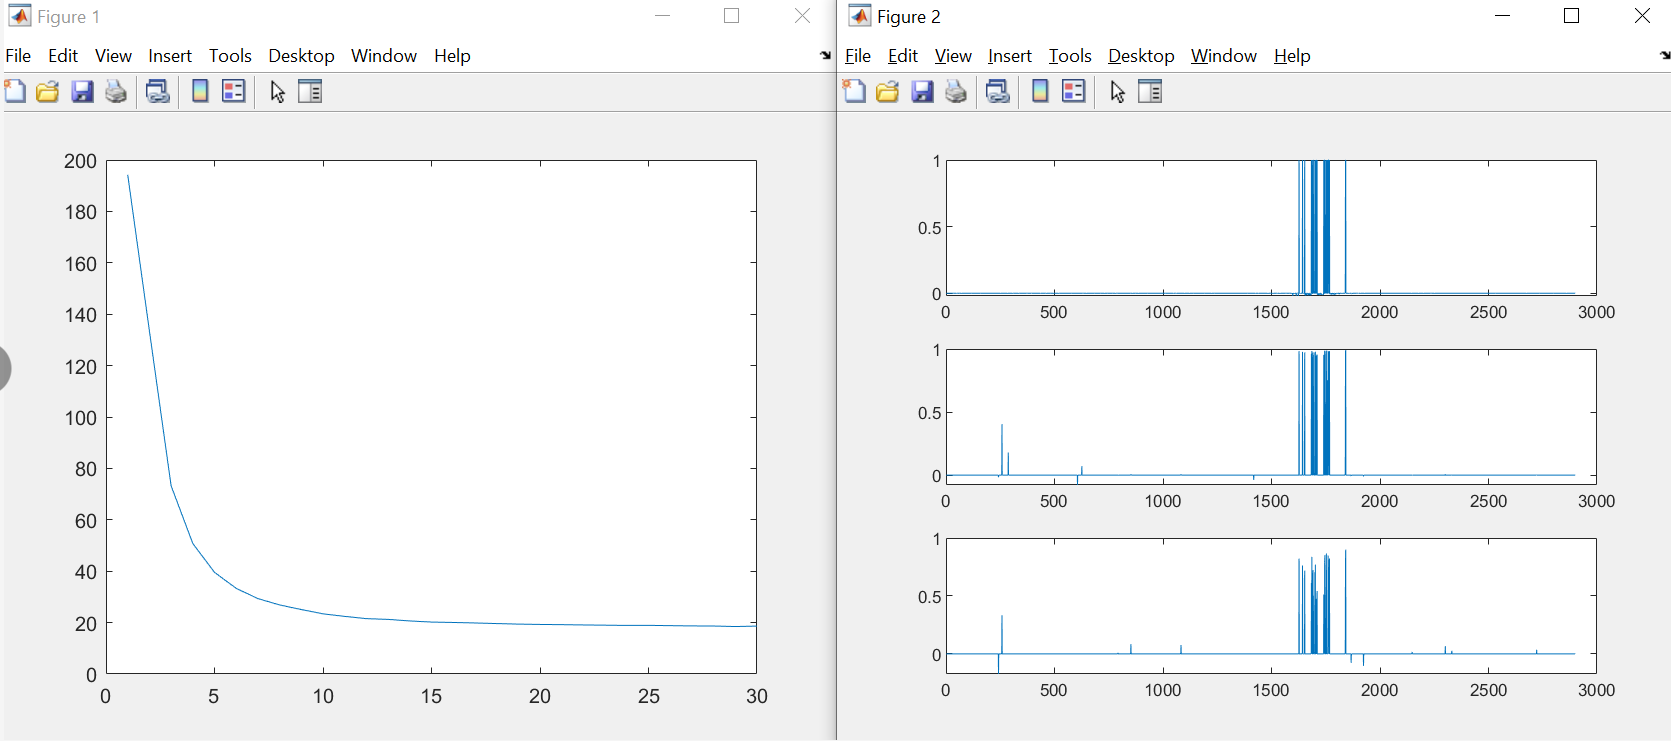

## demo_pmala_diabets

In [191]:
# Illustrative example: Bayesian lasso
# Application of "proximal unadjusted Langevin algorithm" (P-ULA) and "proximal Metropolis adjusted Langevin algorithm" (P-MALA) 
# [1] to the diabetes data of Efron, B., Hastie, T., Johnstone, I. & Tibshirani, R. (2004), "Least angle regression", Ann. Statist. 32(2), 407-499.

# Load data
# y  - observation vector with responses to treatment
# A  - regressor matrix
# sigma2 - maximum marginal likelihood estimate of hyper-parameter \sigma^2
# alpha  - maximum marginal likelihood estimate of hyper-parameter \alpha

import scipy.io as sio
diabetes_data = sio.loadmat('data/diabetesData.mat')
y = diabetes_data['y']
A = diabetes_data['A']
sigma2 = diabetes_data['sigma2']
alpha = diabetes_data['alpha']

# Setup P-ULA and P-MALA

# Setup handler for g(x) = \log\pi(x)
def g(x):
    # print((y-np.dot(A,x)).shape)
    # print(np.linalg.norm(y-np.dot(A,x),ord=2)^2)
    return -(np.linalg.norm(y-np.dot(A,x),2)**2)/(2*sigma2) -alpha*np.linalg.norm(x,1)

# Setup handler for proximity mapping of g1(x) = -alpha*norm(x,1)
def proxg1(x,lamda):
    #print(np.maximum(np.abs(x),alpha*lamda))
    return np.sign(x)*(np.maximum(np.abs(x),alpha*lamda)-alpha*lamda)
                  
# Setup handler for gradient mapping of g2(x) = -(norm(y-A*x,2)^2)/(2*sig2)
def gradg2(x):
    return -np.dot(np.transpose(A),(np.dot(A,x)-y))/sigma2

# Setup handler for proximity mapping of g(x) approximated by forward-backward splitting
def proxg(x,lamda):
    return proxg1(x+lamda*gradg2(x),lamda)

# Simulate from the posterior \pi(X|Y) using the proximal-point MALA
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = sigma2/3 # value of time-discretisation step "delta"
options['display'] = 1 # do not display progressbar
options['updateDelta'] = 20 # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
options['targetRate']=0.5
X0 = np.zeros((10,1)) # set initial state
print(np.size(X0))
# Run P-ULA
XchainPULA,timePULA = pula(X0,proxg,options)

# Run P-MALA
XchainPMALA,gTrace,acceptTrace,timePMALA,delta = pmala(X0,g,proxg,options)
print(XchainPULA.shape)
begin = int(options['burnIn'])
medPULA  = np.median(XchainPULA[begin:,:],axis=0)
medPMALA = np.median(XchainPMALA[begin:,:],axis=0)
p05PULA = np.quantile(XchainPULA[begin:,:],0.05,axis=0)
p95PULA  = np.quantile(XchainPULA[begin:,:],0.95,axis=0)
p05PMALA = np.quantile(XchainPMALA[begin:,:],0.05,axis=0)
p95PMALA = np.quantile(XchainPMALA[begin:,:],0.95,axis=0)
print(medPULA)

10
(110000, 10, 1)
[[  -2.69591007]
 [-213.064084  ]
 [ 524.29921559]
 [ 307.39000424]
 [-150.01078211]
 [  -8.56998728]
 [-178.38580231]
 [  67.75312246]
 [ 516.57727431]
 [  59.02946533]]


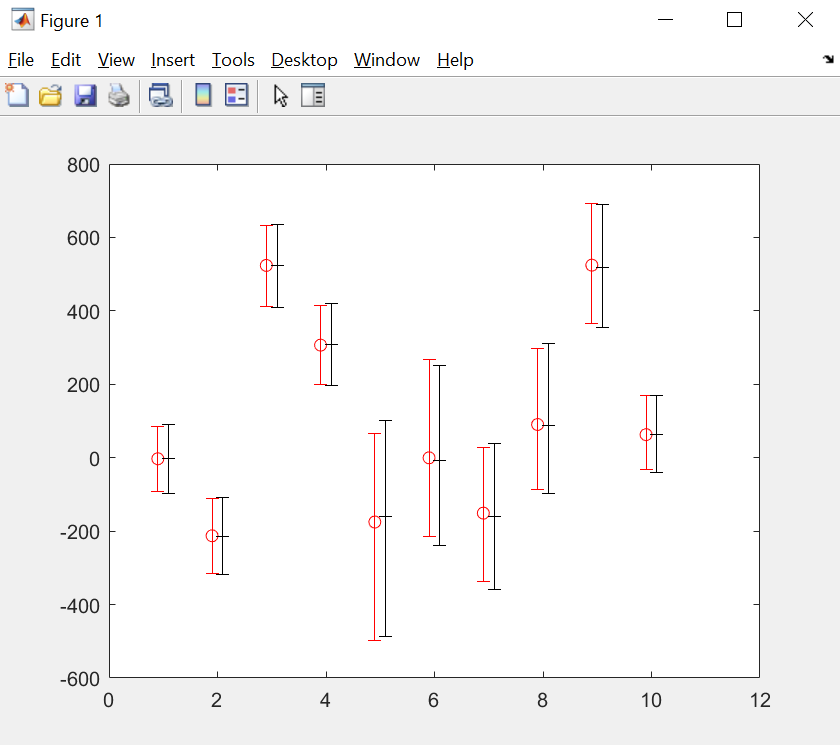

# demo_pula_illustrativeExample
Illustrative example: 4 univariate distibutions with different tails

Demonstration of the "proximal unadjusted Langevin algorithm" (P-ULA)

## 1 - Simulate from univariate Laplace distribution

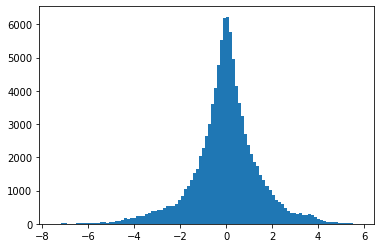

In [192]:
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
    return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.matrix(np.random.rand(1, 1)) # set initial state

# Run P-ULA
Xchain1,time1 = pula(X0,proxg1,options)
Xchain1 = Xchain1.reshape(Xchain1.shape[0],Xchain1.shape[1])
plt.hist(Xchain1[10000:],101)
plt.show()

## 2 - Simulate from univariate Gaussian distribution


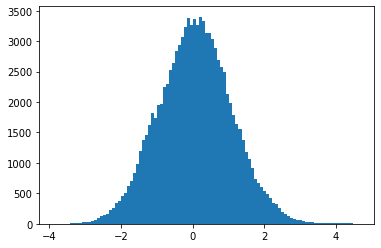

In [193]:
# Define proximity mapping of g(x) = log\pi(x)
def proxg2(X, lamda):
    return X/(1+lamda)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.random.rand(1, 1) # set initial state

# Run P-ULA
Xchain2,time2 = pula(X0,proxg2,options)
Xchain2 = Xchain2.reshape(Xchain2.shape[0],Xchain2.shape[1])
plt.hist(Xchain2[10000:],101)
plt.show()

## 3 - Simulate from univariate quartic (4th order polynomial) distribution


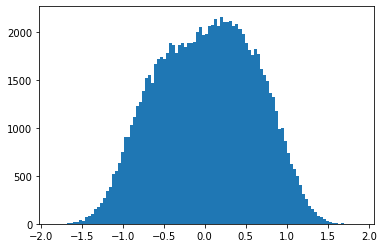

In [194]:
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
  p = 1.0/(4.*lamda)
  q = 1.0*X/(4.*lamda)
  w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
  w = pow(w3, (1./3))
  u = p/(3.*w) - w
  return u

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.random.rand(1, 1) # set initial state
# Run P-ULA
Xchain3, time_s3 = pula(X0,proxg3,options)
Xchain3 = Xchain3.reshape(Xchain3.shape[0],Xchain3.shape[1])
plt.hist(Xchain3[10000:],101)
plt.show()

## 4 - Simulate from univariate uniform  distribution


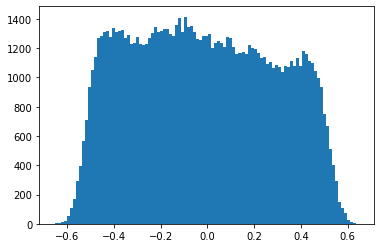

In [195]:
# Define proximity mapping of g(x) = log\pi(x)
def proxg4(X, lamda):
    return min(max(-1/2,X),1/2)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.002 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
X0 = np.random.rand(1, 1) # set initial state

# Run P-ULA
Xchain4, time_s4 = pula(X0,proxg4,options)
Xchain4 = Xchain4.reshape(Xchain4.shape[0],Xchain4.shape[1])
plt.hist(Xchain4[10000:],101)
plt.show()

## Display results


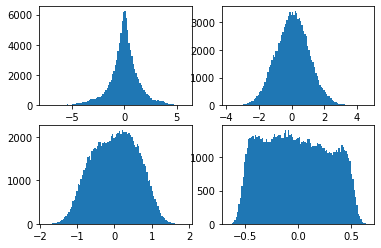

In [196]:
# Run P-ULA
plt.subplot(2,2,1)
plt.hist(Xchain1[10000:],101)

plt.subplot(2,2,2)
plt.hist(Xchain2[10000:],101)

plt.subplot(2,2,3)
plt.hist(Xchain3[10000:],101)

plt.subplot(2,2,4)
plt.hist(Xchain4[10000:],101)
plt.show()


# demo_pmala_illustrativeExample


Illustrative example: 4 univariate distibutions with different tails

Demonstration of the "proximal Metropolis adjusted Langevin algorithm" (P-MALA)

## 1 - Simulate from univariate Laplace distribution

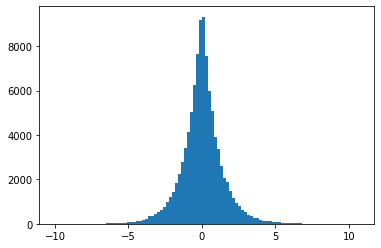

In [197]:
# Define g = \log\pi(x)
def g1(X):
    return -np.abs(X)
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
    #print(np.sign(X),np.abs(X),lamda)
    return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.matrix(np.random.rand(1, 1)) # set initial state
# Run P-MALA
Xchain1,gTrace1,acceptTrace1,time_s1,delta1 = pmala(X0,g1,proxg1,options)
Xchain1 = Xchain1.reshape(Xchain1.shape[0],Xchain1.shape[1])
plt.hist(Xchain1[10000:],101)
plt.show()


## 2 - Simulate from univariate Gaussian distribution


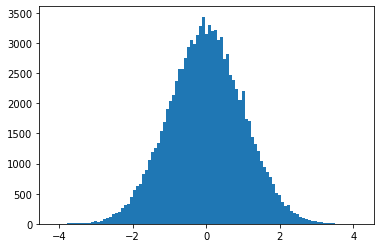

In [198]:
# Define g = \log\pi(x)
def g2(X):
    return -0.5 * pow(X,2)
# Define proximity mapping of g(x) = log\pi(x)
def proxg2(X, lamda):
    return X/(1+lamda)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
Xchain2,gTrace2,acceptTrace2,time_s2,delta2 = pmala(X0,g2,proxg2,options)
Xchain2 = Xchain2.reshape(Xchain2.shape[0],Xchain2.shape[1])
plt.hist(Xchain2[10000:],101)
plt.show()

## 3 - Simulate from univariate quartic (4th order polynomial) distribution


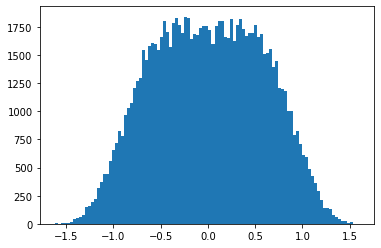

In [199]:
# Define g = \log\pi(x)
def g3(X):
    return -pow(X,4)
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
    p = 1.0/(4.*lamda)
    q = 1.0*X/(4.*lamda)
    w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
    w = pow(w3, (1./3))
    u = p/(3.*w) - w
    return u

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
Xchain3,gTrace3,acceptTrace3,time_s3,delta3 = pmala(X0,g3,proxg3,options)
Xchain3 = Xchain3.reshape(Xchain3.shape[0],Xchain3.shape[1])
plt.hist(Xchain3[10000:],101)
plt.show()

## 4 - Simulate from univariate uniform  distribution


C:\Users\Cecile\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


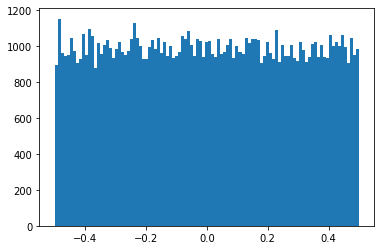

In [200]:
# Define g = \log\pi(x)
def g4(X):
    return np.log(np.double(abs(X)<0.5))
# Define proximity mapping of g(x) = log\pi(x)
def proxg4(X, lamda):
    return min(max(-1/2,X),1/2)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1)/2 -1/2 # set initial state
# Run P-MALA
Xchain4,gTrace4,acceptTrace4,time_s4,delta4 = pmala(X0,g4,proxg4,options)
Xchain4 = Xchain4.reshape(Xchain4.shape[0],Xchain4.shape[1])
plt.hist(Xchain4[10000:],101)
plt.show()

## Display results


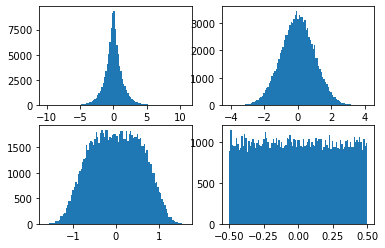

In [201]:
# Run P-MALA
plt.subplot(2,2,1)
plt.hist(Xchain1[10000:],101)

plt.subplot(2,2,2)
plt.hist(Xchain2[10000:],101)

plt.subplot(2,2,3)
plt.hist(Xchain3[10000:],101)

plt.subplot(2,2,4)
plt.hist(Xchain4[10000:],101)
plt.show()
